In [1]:
# pip install -e git+git://github.com/raoulbia/nlp_utils.git#egg=nlp_utils
import re
import requests
import pandas as pd
from pandas.io.json import json_normalize
import nlp_utils

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load data

In [3]:
# dev url
url = "https://raw.githubusercontent.com/aswalin/SQuAD/master/data/dev-v1.1.json"

# train url
# url = "https://raw.githubusercontent.com/aswalin/SQuAD/master/data/train-v1.1.json"

r = requests.get(url)
json_dict = r.json()

In [4]:
# Print Corpora Titles
# print(list(json_normalize(json_dict,'data')['title']))

### Convert to Tidy DF

In [5]:
def convert_squad_to_tidy_df(json_dict, corpus):
    """This function converts the SQuAD JSON data to a Tidy Data Pandas Dataframe.
    
    :param obj json_dict: squad json data
    :param str corpus: name of squad corpora to select subset from json object
    
    :returns: converted json data
    :rtype: pandas dataframe
    
    """
    data = [c for c in json_dict['data'] if c['title']==corpus][0]
    df = pd.DataFrame()
    data_paragraphs = data['paragraphs']
    for article_dict in data_paragraphs:
        row = []
        for answers_dict in article_dict['qas']:
            for answer in answers_dict['answers']:
                row.append((article_dict['context'], 
                            answers_dict['question'], 
                            answers_dict['id'],
                            answer['answer_start'],
                            answer['text']
                           ))
        df = pd.concat([df, pd.DataFrame.from_records(row, columns=['context', 'question', 'id', 'answer_start', 'text'])], axis=0, ignore_index=True)
        df.drop_duplicates(inplace=True)
    return df

In [6]:
corpus = 'Super_Bowl_50' # only in dev dataset
# corpus = 'Culture'
df = convert_squad_to_tidy_df(json_dict, corpus)#.reset_index()
print(len(df))
df.head()

1370


,context,question,id,answer_start,text
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec,177,Denver Broncos
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed,249,Carolina Panthers
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,56be4db0acb8001400a502ee,403,"Santa Clara, California"
3,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,56be4db0acb8001400a502ee,355,Levi's Stadium
4,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,56be4db0acb8001400a502ee,355,Levi's Stadium in the San Francisco Bay Area a...


### Data Processing

In [7]:
df_proc = df.copy()
df_proc['context'] = df_proc['context'].apply(lambda x: nlp_utils.pre_process(x))
df_proc['question'] = df_proc['question'].apply(lambda x: nlp_utils.pre_process(x))

In [8]:
df_proc.head()

,context,question,id,answer_start,text
0,[super bowl 50 american football game determin...,[nfl team represent afc super bowl 50],56be4db0acb8001400a502ec,177,Denver Broncos
1,[super bowl 50 american football game determin...,[nfl team represent nfc super bowl 50],56be4db0acb8001400a502ed,249,Carolina Panthers
2,[super bowl 50 american football game determin...,[super bowl 50 take place],56be4db0acb8001400a502ee,403,"Santa Clara, California"
3,[super bowl 50 american football game determin...,[super bowl 50 take place],56be4db0acb8001400a502ee,355,Levi's Stadium
4,[super bowl 50 american football game determin...,[super bowl 50 take place],56be4db0acb8001400a502ee,355,Levi's Stadium in the San Francisco Bay Area a...


In [9]:
# print(df.iloc[0,0])
print(len(df_proc.iloc[0,0]))
print(df_proc.iloc[0,0])

4
['super bowl 50 american football game determine champion national football league nfl 2015 season', 'american football conference afc champion denver bronco defeat national football conference nfc champion carolina panther 2410 earn third super bowl title', 'game play february 7 2016 levis stadium san francisco bay area santa clara california', '50th super bowl league emphasize golden anniversary various goldthemed initiative well temporarily suspend tradition name super bowl game roman numeral game know super bowl logo prominently feature arabic numeral 50']


### Feature Engineering

#### Bag of Words

The bag of words model represents each text document as a numeric vector where 

* each dimension is a specific word from the corpus 
* and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. 

The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [10]:
cv = CountVectorizer(min_df=0., max_df=1.)
sents = df_proc.iloc[0, 0].copy()
cv_matrix = cv.fit_transform(sents)
cv_matrix = cv_matrix.toarray()
# print(cv_matrix)

# get all unique words in the corpus
vocab = cv.get_feature_names()
print('ndim: {}'.format(len(vocab)))

# show document feature vectors
print(sents[0]) # show first sentence
pd.DataFrame(cv_matrix, columns=vocab)

ndim: 56
super bowl 50 american football game determine champion national football league nfl 2015 season


,2015,2016,2410,50,50th,afc,american,anniversary,arabic,area,...,season,stadium,super,suspend,temporarily,third,title,tradition,various,well
0,1,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,1,1,0,...,0,0,3,1,1,0,0,1,1,1


#### N-Grams

Each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

In [11]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
sents = df_proc.iloc[0, 0].copy()
bv_matrix = bv.fit_transform(sents)
bv_matrix = bv_matrix.toarray()

# get all unique words in the corpus
vocab = bv.get_feature_names()
print('ndim: {}'.format(len(vocab)))

# show document feature vectors
print(sents[0]) # show first sentence
pd.DataFrame(bv_matrix, columns=vocab)

ndim: 67
super bowl 50 american football game determine champion national football league nfl 2015 season


,2015 season,2016 levis,2410 earn,50 american,50th super,afc champion,american football,anniversary various,arabic numeral,area santa,...,san francisco,santa clara,stadium san,super bowl,suspend tradition,temporarily suspend,third super,tradition name,various goldthemed,well temporarily
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,1,0,...,0,0,0,3,1,1,0,1,1,1


#### TF-IDF Model

The TF-IDF based feature vectors for each of our text documents show scaled and normalized values as compared to the raw Bag of Words model values. 

$idf(term) = ln(\frac{n_{documents}}{n_{documents \ containing \ term}})$

**General Idea**
* the inverse document frequency (and thus tf-idf) is very low (near zero) for words that occur in many of the documents in a collection
* this is how this approach decreases the weight for common words. 
* The inverse document frequency will be a higher number for words that occur in fewer of the documents in the collection. 
* the value of idf is used to weight tf: tf-idf = tf * idf
  * a given tf is weighted by its corresponding idf value
  * if idf is small, it will diminish the weight of the tf
  * if idf is large, it will tend to leave tf unchanged

**Example 1**

* a document containing 100 words wherein the word cat appears 3 times
* tf = 3 / 100 = 0.03
* Now, assume we have 10 million documents and the word cat appears in one thousand of these
* Then, idf = log(10,000,000 / 1,000) = 4
* Thus, Tf-idf = 0.03 * 4 = 0.12

**Example 2**

* same as above: tf = 3 / 100 = 0.03. 
* the word cat appears in ten thousand of these 
* Then, idf = log(10,000,000 / 1,0000) = 3
* Thus, Tf-idf = 0.03 * 3 = 0.09

In [12]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
sents = df_proc.iloc[0, 0].copy()
tv_matrix = tv.fit_transform(sents)
tv_matrix = tv_matrix.toarray()

# get all unique words in the corpus
vocab = tv.get_feature_names()
print('ndim: {}'.format(len(vocab)))

# show document feature vectors
print(sents[0]) # show first sentence
pd.DataFrame(tv_matrix, columns=vocab)

ndim: 56
super bowl 50 american football game determine champion national football league nfl 2015 season


,2015,2016,2410,50,50th,afc,american,anniversary,arabic,area,...,season,stadium,super,suspend,temporarily,third,title,tradition,various,well
0,0.304057,0.000000,0.000000,0.239722,0.00000,0.000000,0.239722,0.00000,0.00000,0.000000,...,0.304057,0.000000,0.194076,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000
1,0.000000,0.000000,0.213052,0.000000,0.00000,0.213052,0.167973,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.135988,0.00000,0.00000,0.213052,0.213052,0.00000,0.00000,0.00000
2,0.000000,0.283896,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.283896,...,0.000000,0.283896,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000
3,0.000000,0.000000,0.000000,0.138926,0.17621,0.000000,0.000000,0.17621,0.17621,0.000000,...,0.000000,0.000000,0.337417,0.17621,0.17621,0.000000,0.000000,0.17621,0.17621,0.17621


#### Cosine Similarity

The lower the angle between the documents, the closer and more similar they are as depicted in the following figure.

In [13]:
# produce tfidf matrix including question
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
sents = df_proc.iloc[0, 0].copy()
sents.append(df_proc.iloc[0, 1][0])

tv_matrix = tv.fit_transform(sents)
tv_matrix = tv_matrix.toarray()

similarity_matrix = cosine_similarity(X = tv_matrix, Y = None)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4
0,1.000000,0.388226,0.039437,0.218747,0.256924
1,0.388226,1.000000,0.000000,0.073735,0.131515
2,0.039437,0.000000,1.000000,0.045956,0.000000
3,0.218747,0.073735,0.045956,1.000000,0.203098
4,0.256924,0.131515,0.000000,0.203098,1.000000


In [14]:
# Get sentence most similar to Question

# produce tfidf matrix including question
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
sents = df_proc.iloc[0, 0].copy()
sents.append(df_proc.iloc[0, 1][0])

tv_matrix = tv.fit_transform(sents)
tv_matrix = tv_matrix.toarray()

# tv_matrix[-1] is the last row i.e. the question
q = tv_matrix[-1]
q = q.reshape(1, len(q)) # Note: here the order of reshaping matters
# print('q shape: {}'.format(q.shape))

sims = cosine_similarity(X = q, Y = tv_matrix) # [1 x 58] x [5, 58] >> [1 x 58] (sklearn takes of transposing)
sims = sims[0] # sims is a nested list hence we use [0]
print('sims: {}'.format(sims))

# we can use argsort() to find the index in sims IF it were sorted ASC
# i.e. we can look at sims.argosrt() to know at which position in sims the second largest value can be found
idx_if_sorted_sims = sims.argsort() # argsort() returns the indices that would sort an array ASC
print('indices that would sort an array ASC: {}'.format(idx_if_sorted_sims))

# specifically, we want to know the index of the second last position in sims.argosrt()
most_sim_idx = idx_if_sorted_sims[-2]

# make sure that we have a similarity > 0:
print('\nQuestion: {}'.format(df.iloc[0, 1]))
print('\nText: {}'.format(df.iloc[0, 0]))
most_sim_score = sorted(sims)[-2]
if not most_sim_score == 0:  
    # get most similar sentence using most sim idx
    print('\nMost similar sentence w.r.t question: {}'.format(sents[most_sim_idx]))
else:
    print('\nNo sentence in corpus is similar to the question...')

sims: [0.25692437 0.13151515 0.         0.20309805 1.        ]
indices that would sort an array ASC: [2 1 3 0 4]

Question: Which NFL team represented the AFC at Super Bowl 50?

Text: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.

Most similar sentence w.r.t question: s

#### Clustering

**Unsupervised hierarchical clustering**

* There are two types of hierarchical clustering algorithms namely, agglomerative and divisive methods.
* agglomerative clustering algorithm uses a bottom up approach i.e. 
  * each observation or document starts in its own cluster 
  * and clusters are successively merged together using a distance metric to measure the distances between data points and a linkage merge criterion. 
* The selection of the linkage criterion governs the merge strategy. 
* Some examples of linkage criteria are 
  * Ward
  * Complete linkage
  * Average linkage

In [15]:
# Note: similarity matrix contains the question
Z = linkage(similarity_matrix, 'ward')

# each step (row) of the linkage matrix tells us which data points (or clusters) were merged together. 
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,0,1,0.887044,2
1,3,4,1.13005,2
2,5,6,1.36476,4
3,2,7,1.58202,5


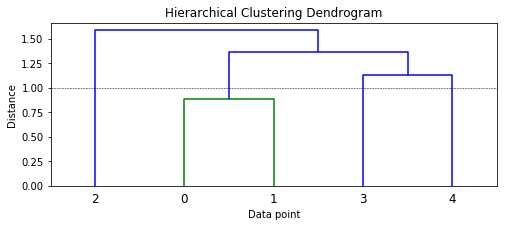

In [16]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [17]:
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([pd.DataFrame(sents), cluster_labels], axis=1)

,0,ClusterLabel
0,super bowl 50 american football game determine...,1
1,american football conference afc champion denv...,1
2,game play february 7 2016 levis stadium san fr...,4
3,50th super bowl league emphasize golden annive...,2
4,nfl team represent afc super bowl 50,3


#### Lexical Parsing

In [18]:
#!/usr/bin/env python3

from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import CoreNLPDependencyParser

parser = CoreNLPParser(url='http://188.166.145.126:9000', tagtype='pos')
dep_parser = CoreNLPDependencyParser(url='http://188.166.145.126:9000')

In [19]:
text = 'What is the airspeed of an unladen swallow ?'
text = 'I want to drink wine for dinner'

# parser
print(list(parser.parse(text.split())))

# dependency parser
iter = dep_parser.parse(text.split())
dep = next(iter)

print(list(dep.tree()))

for t in dep.triples():
    print(t)


[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('PRP', ['I'])]), Tree('VP', [Tree('VBP', ['want']), Tree('S', [Tree('VP', [Tree('TO', ['to']), Tree('VP', [Tree('VB', ['drink']), Tree('NP', [Tree('NP', [Tree('NN', ['wine'])]), Tree('PP', [Tree('IN', ['for']), Tree('NP', [Tree('NN', ['dinner'])])])])])])])])])])]
['I', Tree('drink', ['to', 'wine', Tree('dinner', ['for'])])]
(('want', 'VBP'), 'nsubj', ('I', 'PRP'))
(('want', 'VBP'), 'xcomp', ('drink', 'VB'))
(('drink', 'VB'), 'mark', ('to', 'TO'))
(('drink', 'VB'), 'dobj', ('wine', 'NN'))
(('drink', 'VB'), 'nmod', ('dinner', 'NN'))
(('dinner', 'NN'), 'case', ('for', 'IN'))


In [20]:
print(len(df_proc.iloc[0,0]))
print(len(nltk.sent_tokenize(df.iloc[0,0])))
a = nltk.sent_tokenize(df.iloc[0,0])
b = df_proc.iloc[0,0]
# a = ['South Africa', 'India', 'United States']
# b = ['ZA', 'IN', 'US']
for i,j in zip(a,b):
    print(i,j)

4
4
Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. super bowl 50 american football game determine champion national football league nfl 2015 season
The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. american football conference afc champion denver bronco defeat national football conference nfc champion carolina panther 2410 earn third super bowl title
The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. game play february 7 2016 levis stadium san francisco bay area santa clara california
As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which 

In [21]:
# see nltk-stanford.ipynb
# from edbullen

regexpSubj = re.compile(r'subj')
regexpObj = re.compile(r'obj')
regexpNouns = re.compile("^N.*|^PR.*")

for sentence, sent_orig in zip(df_proc.iloc[0,0], nltk.sent_tokenize(df.iloc[0,0])):
    print("----------------------")
    nouns = []
    tokens = sentence.split()
#     print('Tokens: {}'.format(tokens))
    tags = parser.tag(tokens)
    print('Tagged Tokens: {}'.format(tags))
    for tag_pair in tags:
        if tag_pair[1]=='NN':
            nouns.append(tag_pair[0])
                
    result = dep_parser.raw_parse(sentence)
    dep = next(result)
    root = [dep.root["word"]]
    
    subj, obj = [], []
    for t in dep.triples():
        if regexpNouns.search(t[1]):
            subj.append(t[2][0])
        if regexpSubj.search(t[1]):
            subj.append(t[2][0])
        if regexpObj.search(t[1]):
            obj.append(t[2][0])
            
    print('\nSentence: {}'.format(sent_orig))
    print('Subject: {}\nTopic: {}\nObject: {}'.format(subj, root, obj))
    print('Nouns: {}'.format(nouns))

----------------------
Tagged Tokens: [('super', 'JJ'), ('bowl', 'NN'), ('50', 'CD'), ('american', 'NN'), ('football', 'NN'), ('game', 'NN'), ('determine', 'VB'), ('champion', 'JJ'), ('national', 'JJ'), ('football', 'NN'), ('league', 'NN'), ('nfl', 'NN'), ('2015', 'CD'), ('season', 'NN')]

Sentence: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.
Subject: ['bowl']
Topic: ['determine']
Object: ['nfl']
Nouns: ['bowl', 'american', 'football', 'game', 'football', 'league', 'nfl', 'season']
----------------------
Tagged Tokens: [('american', 'JJ'), ('football', 'NN'), ('conference', 'NN'), ('afc', 'NN'), ('champion', 'NN'), ('denver', 'NN'), ('bronco', 'NN'), ('defeat', 'NN'), ('national', 'JJ'), ('football', 'NN'), ('conference', 'NN'), ('nfc', 'NN'), ('champion', 'NN'), ('carolina', 'NN'), ('panther', 'NN'), ('2410', 'CD'), ('earn', 'VBP'), ('third', 'JJ'), ('super', 'JJ'), ('bowl', 'NN'), ('title', 'NN')]

S

#### Some useful Links

* https://github.com/aswalin/SQuAD.git
* https://github.com/priya-dwivedi/cs224n-Squad-Project
* https://mindtrove.info/flatten-nested-json-with-pandas/
* https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
* https://github.com/dipanjanS/text-analytics-with-python/tree/master/Old-First-Edition/source_code